# Лабораторная работа "Системы ОДУ"

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import collections

CALC_TYPE = np.float64

## 0. Задача

Вариант 2, задача VIII.11.2: Уравнение Ван-дер-Поля
$$\begin{cases} y'' + \mu (y^2 - 1)y' + y = 0,~\mu>0 \\ y(0) = 2 \\ y'(0) = 0 \end{cases}$$

Сделаем замену $u = y, ~v=y'$, получим систему
$$ \begin{cases} u' = v \\ v' = \mu (1 - u^2) v - u \\ u(0) = 2 \\ v(0) = 0\end{cases} $$

Будем изучать поведение системы при варьировании параметра $\mu$. Интервал времени выберем $t: 0 < t < 100$.

> Шаг сетки $h$, а также интервал отрисовки графика $y(t)$ будут выбираться таким образом, чтобы продемонстрировать улучшение аппроксимации при увеличении порядка метода.

In [176]:
def task(mu, h, solvers, labels, title, tbounds=(80,100)):
    tmin, tmax = tbounds

    def func(y, t):
        u, v = y
        f0 = v
        f1 = mu*(1 - u**2)*v - u
        return np.array([f0, f1])

    u0 = 2
    v0 = 0
    t0 = 0

    for solver in solvers:
        solver.init_problem(func, t0, np.array([u0, v0]))

    fig, (intc, phsp) = plt.subplots(1, 2)
    fig.set_size_inches(12, 6)

    intc.set_xlabel("$t$")
    intc.set_ylabel("$y$")
    intc.set_title("$Integral ~curve$")
    intc.grid()
    intc.set_xlim([tmin, tmax])

    phsp.set_xlabel("$y$")
    phsp.set_ylabel("$y'$")
    phsp.set_title("$Phase ~portrait$")
    phsp.grid()

    for i, (solver, label) in enumerate(zip(solvers, labels)):
        nsteps = np.ceil((tmax - t0) / solver.get_h()).astype(np.uint64)

        T = []
        Y = []
        Yd = []

        for _ in range(nsteps):
            t, y = solver.step()
            T.append(t)
            Y.append(y[0])
            Yd.append(y[1])

        if i + 1 == len(solvers):
            intc.plot(T, Y, "k--", label=label)
            phsp.plot(Y, Yd, "k--", linewidth=.5)
        else:
            intc.plot(T, Y, label=label)
            phsp.plot(Y, Yd, linewidth=.5)
        
    fig.legend()
    plt.suptitle(f"$Van-der-poll, \mu={mu}$\n${title}, h={h}$")
    fig.show()

### Валидация

Проверять работоспособность будем на более простой задаче

$$\begin{cases} y'' + y = 0.2*cos(t) \\ y(0) = 1 \\ y'(0) = 0 \end{cases}$$

In [3]:
# Solving
#   y'' + y = 0.2*cost
#   y(0) = 1, y'(0) = 0
# Solution
#   y = cost + 0.1*tsint
def validate(solvers, labels, steps, bound, title):
    def test_f(y, t):
        u, v = y
        f0 = v
        f1 = -u + 0.2 * np.cos(t)
        return np.array([f0, f1]).astype(CALC_TYPE)

    for solver in solvers:
        solver.init_problem(test_f, 0, np.array([1, 0]))

    T_real = np.linspace(0, bound, 1000)
    Y_real = 0.1*T_real * np.sin(T_real) + np.cos(T_real)

    plt.plot(T_real, Y_real, "k--", label="$Analytical$")

    for solver, label in zip(solvers, labels):
        T = []
        Y = []
        for _ in range(steps):
            t, y = solver.step()
            T.append(t)
            Y.append(y[0])
        plt.plot(T, Y, label=label, linestyle="-", marker="")
        
    plt.legend()
    plt.grid()
    plt.title(f"$Method~ validation: ~{title}$")
    plt.xlabel("t")
    plt.ylabel("y")
    plt.show()

## 1. Явные методы Рунге-Кутты

### Реализация

In [4]:
class ButcherTable:
    def __init__(self, A, b, c):
        self.validate(A, b, c)
        
        self.A = A.astype(CALC_TYPE)
        self.b = b.astype(CALC_TYPE)
        self.c = c.astype(CALC_TYPE)

    def validate(self, A, b, c):
        assert len(b.shape) == 1
        assert len(c.shape) == 1
        assert len(A.shape) == 2
        assert (A.shape[0] == b.shape[0])
        assert (c.shape[0] == b.shape[0])
        assert c[0] == 0

    def get_s(self):
        return len(self.b)

# R. - K. ODE Solver for system
#   Y' = F(Y, t)
# Given the Cauchy problem
#   Y(0) = Y_0
class RKSolver:    
    def __init__(self, btable, h):
        self.btable = btable
        self.h = float(h)
        self.nsteps = 0

        self.problem = None
        self.t = None
        self.y = None
        self.k = None

    def init_problem(self, func, t0, y0):
        self.func = func
        self.t = float(t0)
        self.y = y0.astype(CALC_TYPE)

        self.k = np.zeros((self.btable.get_s(), len(y0))).astype(CALC_TYPE)

    def step(self):
        ret = self.t, self.y.copy()

        t = self.t
        y = self.y
        f = self.func
        h = self.h

        c = self.btable.c
        a = self.btable.A
        b = self.btable.b

        self.k[:] = 0
        self.k[0] = f(y, t)
        for i in range(1, self.btable.get_s()):
            conv = np.zeros((len(y)))
            for j in range(i):
                conv += a[i][j] * self.k[j]

            self.k[i] = f(y + h * conv, t + c[i]*h)

        self.t += h
        self.y += h * np.dot(self.k.T, b)

        return ret
    
    def get_h(self): return self.h

In [5]:
class RungeKuttaCollection:
    # Creates explicit 1-staged 1-order solver
    # Butcher table:
    #  0 |   |
    # --------
    #    | 1 | 
    @staticmethod
    def create_e1(h):
        c = np.array([0])
        b = np.array([1])
        A = np.array([[0]])

        btable = ButcherTable(A, b, c)
        return RKSolver(btable, h)
    
    # Creates explicit 2-staged 2-order solver
    # Butcher table:
    #   0  |     |     |
    #  2/3 | 2/3 |     |
    # ------------------
    #      | 1/4 | 3/4 |
    @staticmethod
    def create_e2(h):
        c = np.array([0, 2/3])
        b = np.array([.25, .75])
        A = np.array([[0, 0],
                      [2/3, 0]])
        
        btable = ButcherTable(A, b, c)
        return RKSolver(btable, h)
    
    # Creates explicit 3-staged 3-order solver
    # Butcher table:
    #   0  |     |     |     |
    #  1/2 | 1/2 |     |     |
    #   1  | -1  |  2  |     |
    # ------------------------
    #      | 1/6 | 2/3 | 1/6 |
    @staticmethod
    def create_e3(h):
        c = np.array([0, .5, 1])
        b = np.array([1/6, 2/3, 1/6])
        A = np.array([[0,  0, 0],
                      [.5, 0, 0],
                      [-1, 2, 0]])
        
        btable = ButcherTable(A, b, c)
        return RKSolver(btable, h)
    
    # Creates explicit 4-staged 4-order solver
    # Butcher table:
    #   0  |  0  |  0  |  0  |  0  |
    #  1/2 | 1/2 |  0  |  0  |  0  |
    #  1/2 |  0  | 1/2 |  0  |  0  |
    #   1  |  0  |  0  |  1  |  0  |
    # ------------------------------
    #      | 1/6 | 1/3 | 1/3 | 1/6 |
    @staticmethod
    def create_e4(h):
        c = np.array([0, 1/2, 1/2, 1])
        b = np.array([1/6, 1/3, 1/3, 1/6])
        A = np.array([[0,   0,   0, 0],
                      [1/2, 0,   0, 0],
                      [0,   1/2, 0, 0],
                      [0,   0,   1, 0]])
        
        btable = ButcherTable(A, b, c)
        return RKSolver(btable, h)

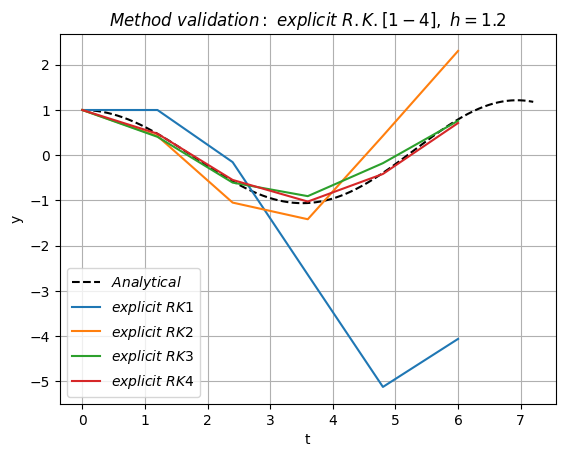

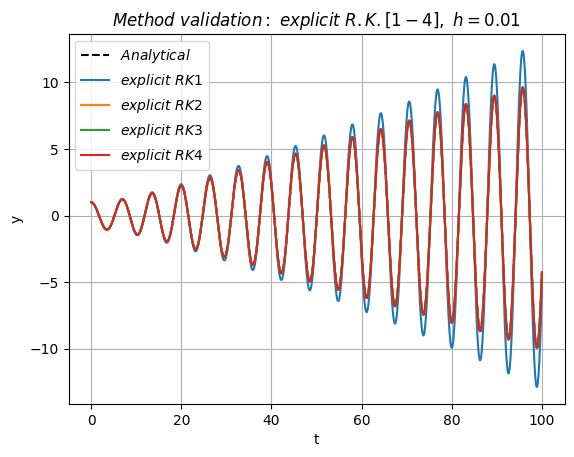

In [6]:
def validate_rk(steps, h):
    solvers = [RungeKuttaCollection.create_e1(h),
               RungeKuttaCollection.create_e2(h),
               RungeKuttaCollection.create_e3(h),
               RungeKuttaCollection.create_e4(h)]

    labels = ["$explicit~ RK1$", "$explicit~ RK2$", "$explicit~ RK3$", "$explicit~ RK4$"]

    validate(solvers, labels, steps, steps*h, f"explicit~ R.K. [1-4],~h={h}")

# Disclaimer:
# I've intentionnaly chosen really big "h"
# To see how method order improves approximation 
validate_rk(6, 1.2)

validate_rk(10000, 1e-2)

### Решение

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_15444\2924195675.py:83: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


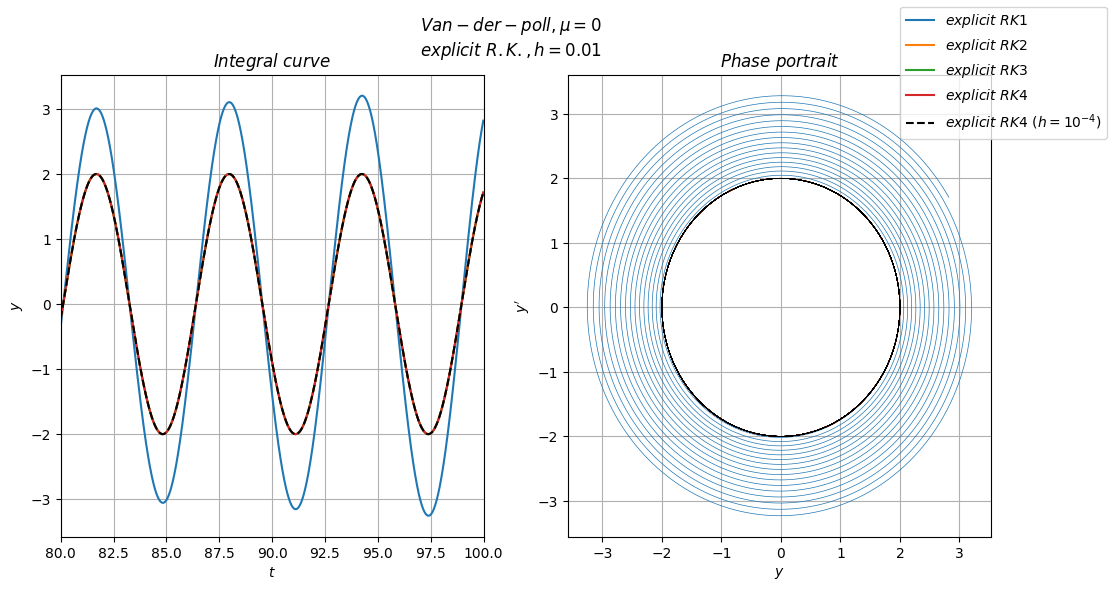

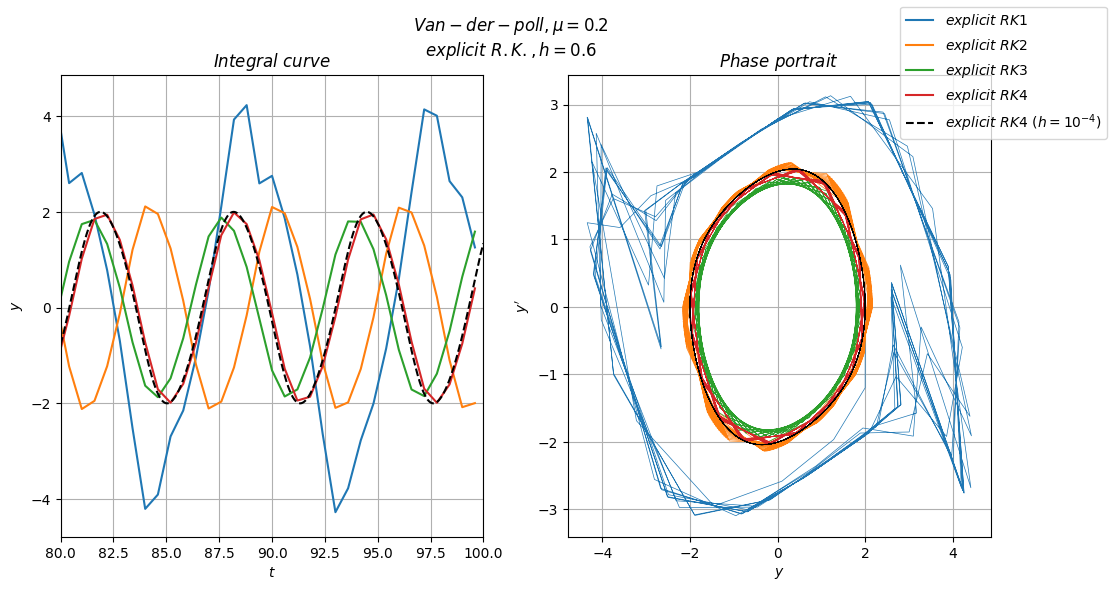

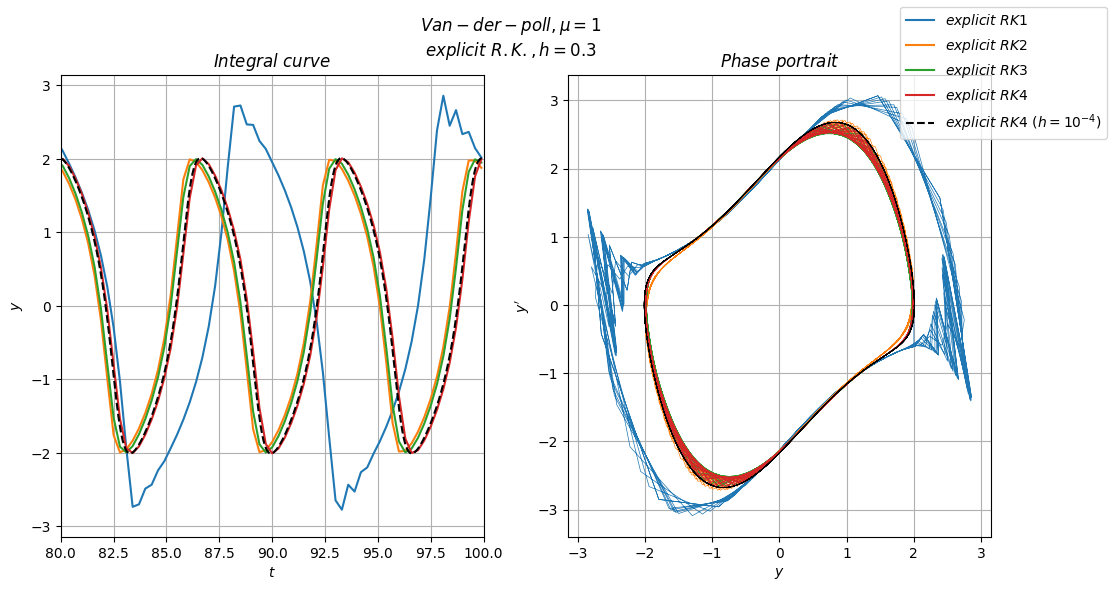

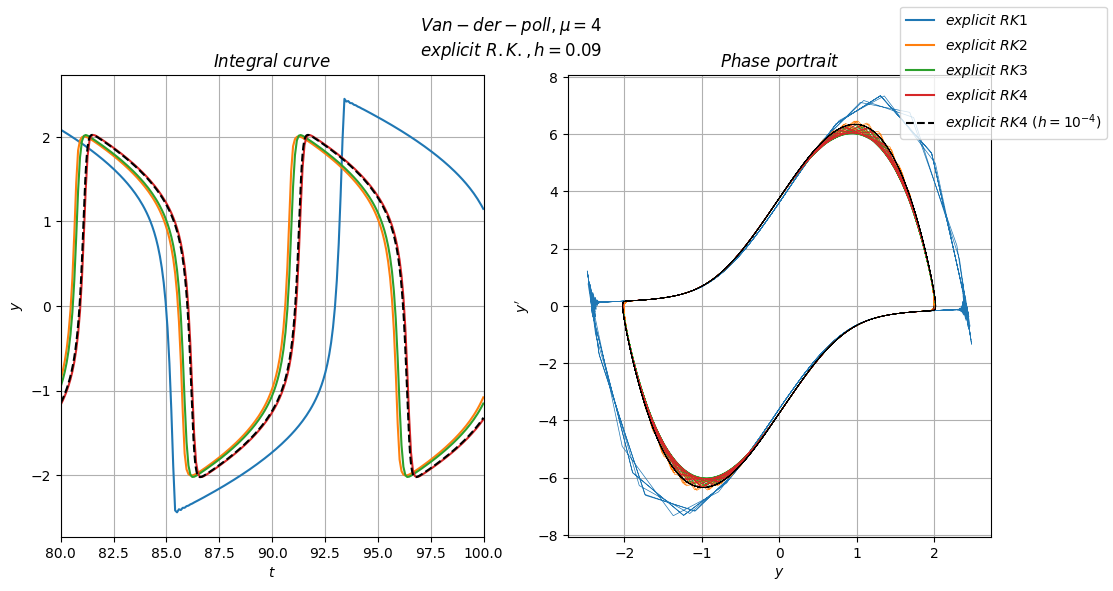

In [58]:
def solution_rk(mu, h):
    solvers = [RungeKuttaCollection.create_e1(h),
               RungeKuttaCollection.create_e2(h),
               RungeKuttaCollection.create_e3(h),
               RungeKuttaCollection.create_e4(h),
               RungeKuttaCollection.create_e4(1e-3)]

    labels = ["$explicit~ RK1$", "$explicit~ RK2$", "$explicit~ RK3$", "$explicit~ RK4$", "$explicit~ RK4 ~(h=10^{-4})$"]

    task(mu, h, solvers, labels, "explicit~ R.K.")

solution_rk(0, 1e-2)
solution_rk(0.2, 6e-1)
solution_rk(1, 3e-1)

solution_rk(4, 9e-2)

## 2. Явные методы Адамса

### Реализация

In [8]:
class AdamsSolver:
    # coeffs - Adams method coefficients, left to right
    def __init__(self, coeffs, h):
        self.coeffs = np.array(coeffs).astype(CALC_TYPE)
        self.ytfcache = None
        self.func = None
        self.h = h

    def init_problem(self, func, t0, y0):
        self.func = func
        self._start_site(t0, y0)

    # Using Runge-Kutta Method to
    # evaluate first N points
    def _start_site(self, t0, y0):
        solver = RungeKuttaCollection.create_e4(self.h)
        solver.init_problem(self.func, t0, y0)

        N = len(self.coeffs)

        self.ytfcache = collections.deque()

        for _ in range(N):
            t, y = solver.step()
            self.ytfcache.append((y, t, self.func(y, t)))
    
    def step(self):
        y_ret, t_ret = self.ytfcache[0][0].copy(), self.ytfcache[0][1]
        y, t = self.ytfcache[-1][0].copy(), self.ytfcache[-1][1]

        conv = np.zeros_like(y)
        for c, (_, __, f) in zip(self.coeffs, self.ytfcache):
            conv += c * f

        y += self.h * conv
        t += self.h

        self.ytfcache.append((y, t, self.func(y, t)))
        self.ytfcache.popleft()
        
        return t_ret, y_ret
    
    def get_h(self): return self.h

In [9]:
class AdamsCollection:
    # Creates explicit 1-order Adams method solver
    # y_{n+1} = y_n + h*f_n
    @staticmethod
    def create_e1(h):
        coeffs = [1]
        return AdamsSolver(coeffs, h)
    
    # Creates explicit 2-order Adams method solver
    # y_{n+1} = y_n + h * (-.5 * f_{n-1} + 1.5*f_n)
    @staticmethod
    def create_e2(h):
        coeffs = [-.5, 1.5]
        return AdamsSolver(coeffs, h)
    
    # Creates explicit 3-order Adams method solver
    # y_{n+1} = y_n + h * ((5/12) * f_{n-2} + (-16/12)*f_{n-1} + (23/12)*f_n)
    @staticmethod
    def create_e3(h):
        coeffs = [5/12, -16/12, 23/12]
        return AdamsSolver(coeffs, h)
    
    # Creates explicit 4-order Adams method solver
    # y_{n+1} = y_n + h * ((-9/24)*f_{n-3} + (37/24) * f_{n-2} + (-59/24)*f_{n-1} + (55/24)*f_n)
    @staticmethod
    def create_e4(h):
        coeffs = [-9/24, 37/24, -59/24, 55/24]
        return AdamsSolver(coeffs, h)

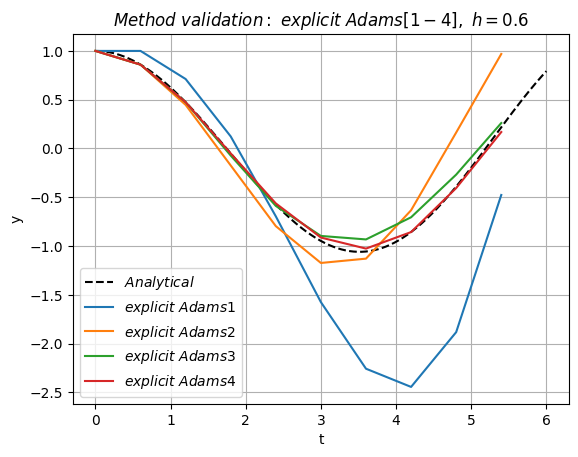

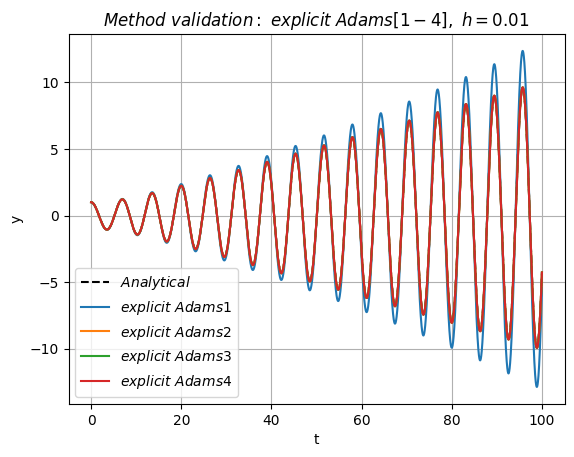

In [94]:
def validate_adams(steps, h):
    solvers = [AdamsCollection.create_e1(h),
               AdamsCollection.create_e2(h),
               AdamsCollection.create_e3(h),
               AdamsCollection.create_e4(h)]
    
               
    labels = ["$explicit~ Adams1$", "$explicit~ Adams2$", "$explicit~ Adams3$", "$explicit~ Adams4$"]

    validate(solvers, labels, steps, steps*h, f"explicit~ Adams [1-4],~h={h}")

validate_adams(10, 6e-1)
validate_adams(10000, 1e-2)

### Решение

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_15444\1310842856.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


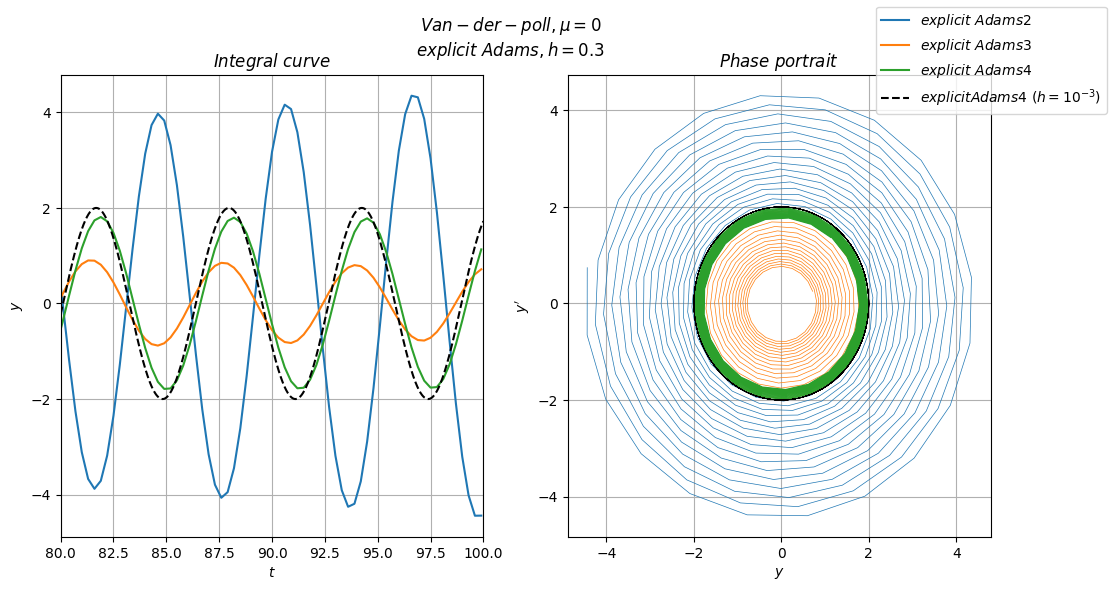

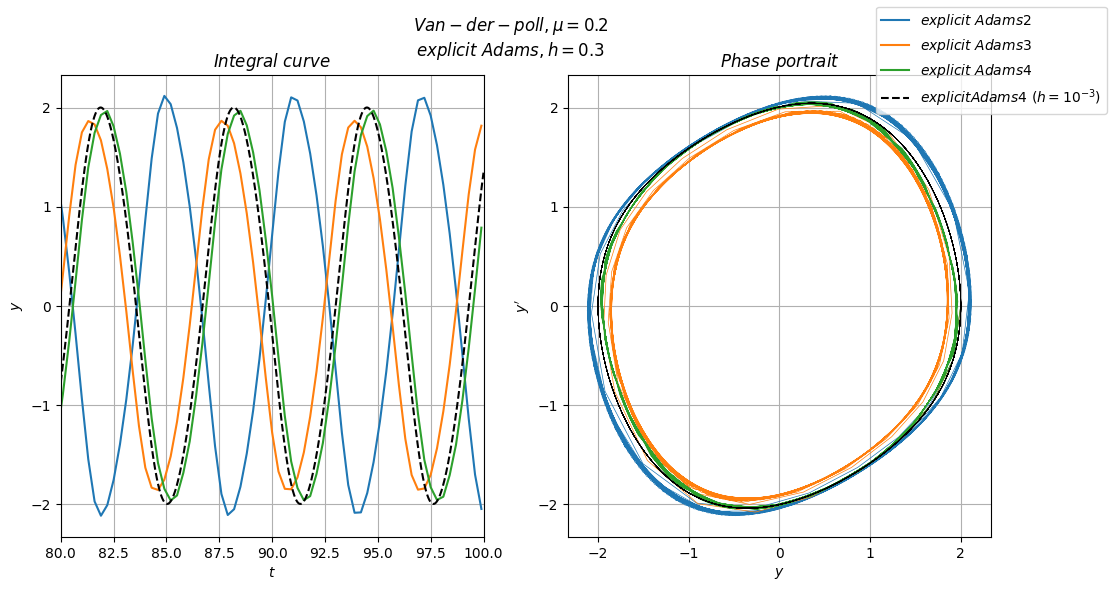

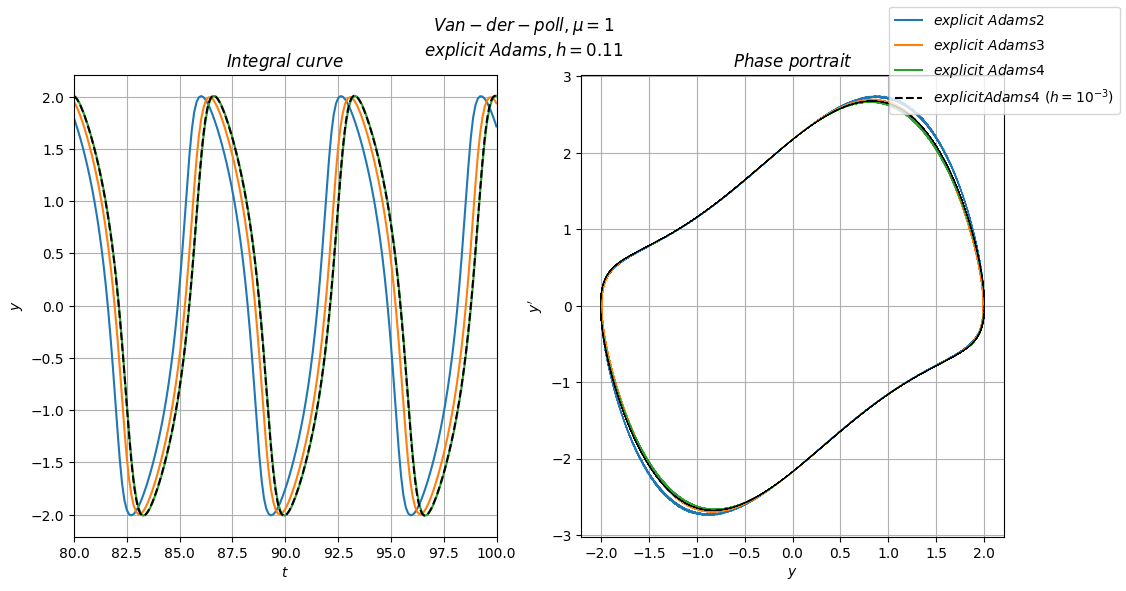

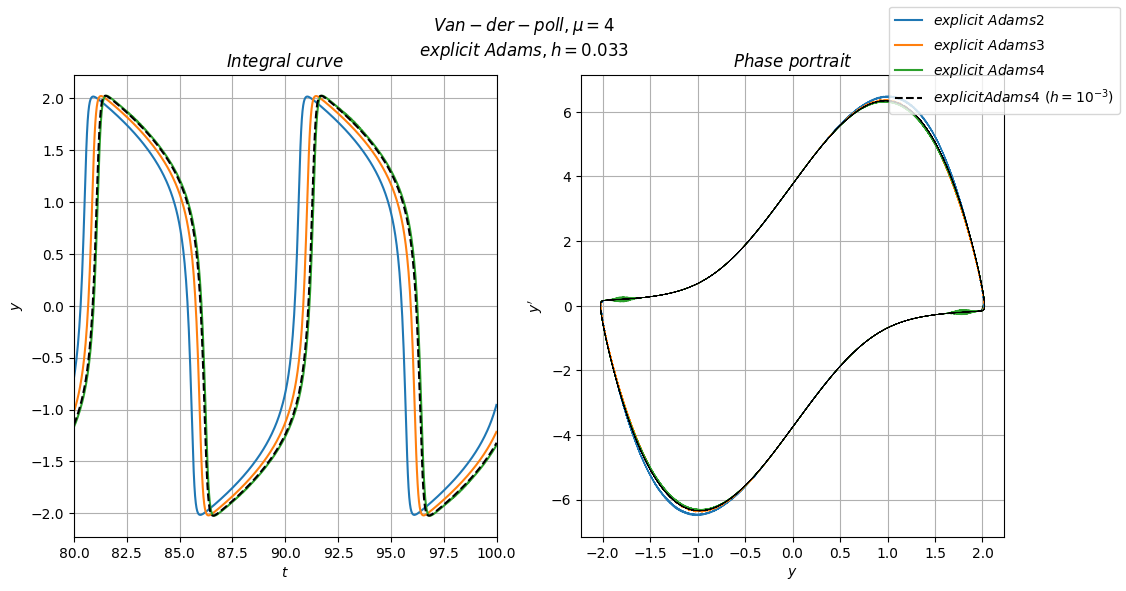

In [11]:
def solution_adams(mu, h):
    solvers = [AdamsCollection.create_e2(h),
               AdamsCollection.create_e3(h),
               AdamsCollection.create_e4(h),
               AdamsCollection.create_e4(1e-3)]

    labels = ["$explicit~ Adams2$", "$explicit~ Adams3$", "$explicit~ Adams4$", "$explicit Adams4 ~(h=10^{-3})$"]

    task(mu, h, solvers, labels, "explicit~ Adams")

solution_adams(0, 3e-1)
solution_adams(0.2, 3e-1)
solution_adams(1, 11e-2)
solution_adams(4, 33e-3)

## 3. Явные Формулы Дифференцирования Назад

### Реализация

In [114]:
class BDFSolver:
    # Params define method
    # y_{n+1} = A*h*f(y_n, t_n) + c_0*y_n + c_1*y_{n-1} + c_2*y_{n-2} + ...
    def __init__(self, A, coeffs, h):
        self.h = h
        self.A = A
        self.coeffs = np.array(coeffs[::-1]).astype(CALC_TYPE)
        self.ytfcache = None
        self.func = None

    def init_problem(self, func, t0, y0):
        self.func = func
        self._start_site(t0, y0)

    # Using Runge-Kutta Method to
    # evaluate first N points
    def _start_site(self, t0, y0):
        solver = RungeKuttaCollection.create_e4(self.h)
        solver.init_problem(self.func, t0, y0)

        N = len(self.coeffs)
        self.ytfcache = collections.deque()

        for _ in range(N):
            t, y = solver.step()
            self.ytfcache.append((y, t, self.func(y, t)))

    def step(self):
        y_ret, t_ret = self.ytfcache[0][0].copy(), self.ytfcache[0][1]
        t, f = self.ytfcache[-1][1], self.ytfcache[-1][2]

        y_new = self.A * self.h * f
        for c, (y, _, __) in zip(self.coeffs, self.ytfcache):
            y_new += c * y

        self.ytfcache.append((y_new, t + self.h, self.func(y_new, t + self.h)))
        self.ytfcache.popleft()
        
        #print(self.ytfcache[0][1], self.ytfcache[1][1])

        return t_ret, y_ret
    
    def get_h(self): return self.h

In [133]:
class BDFCollection:
    # Creates explicit 1-order BDF method
    # y_{n+1} = 1*h*f(y_n, t_n) + 1 * y_n
    @staticmethod
    def create_e1(h):
        return BDFSolver(1, [1], h)
    
    # Creates explicit 2-order BDF method
    # y_{n+1} = 2h*f*(y_n, t_n) + 0 * y_n + 1 * y_{n-1}
    @staticmethod
    def create_e2(h):
        return BDFSolver(2, [0, 1], h)
    
    # Creates explicit 3-order BDF method
    # y_{n+1} = 3h*f*(y_n, t_n) + (-3/2) * y_n + 3 * y_{n-1} + (-1/2)*y_{n-2}
    @staticmethod
    def create_e3(h):
        return BDFSolver(3, [-3/2, 3, -1/2], h)
    
    # Creates explicit 4-order BDF method
    # y_{n+1} = 4h*f*(y_n, t_n) + (-10/3) * y_n + 6 * y_{n-1} + (-2)*y_{n-2} + (1/3)*y_{n-3}
    @staticmethod
    def create_e4(h):
        return BDFSolver(4, [-10/3, 6, -2, 1/3], h)

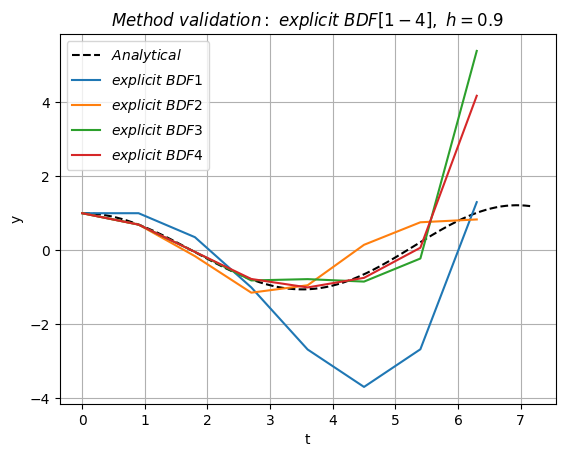

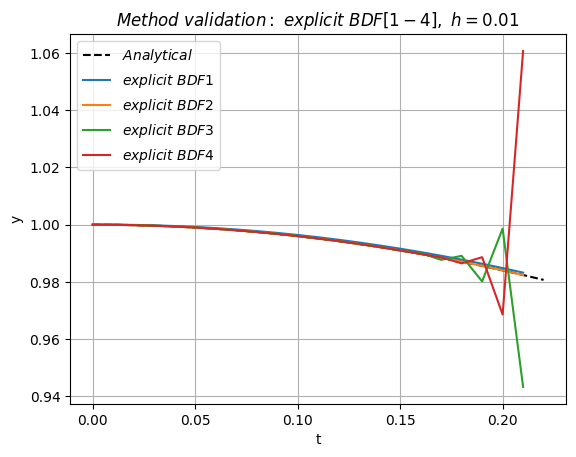

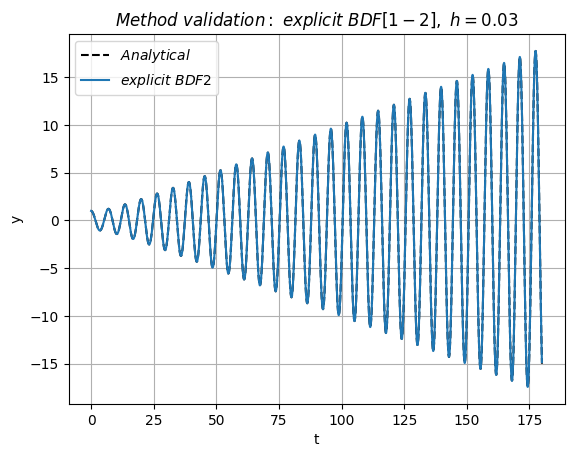

In [198]:
def validate_bdf_1(steps, h):
    solvers = [BDFCollection.create_e1(h),
               BDFCollection.create_e2(h),
               BDFCollection.create_e3(h),
               BDFCollection.create_e4(h)]
    
               
    labels = ["$explicit~ BDF1$", "$explicit~ BDF2$", "$explicit~ BDF3$", "$explicit~ BDF4$"]

    validate(solvers, labels, steps, steps*h, f"explicit~ BDF [1-4],~h={h}")

def validate_bdf_2(steps, h):
    solvers = [BDFCollection.create_e2(h)]
    
               
    labels = ["$explicit~ BDF2$"]

    validate(solvers, labels, steps, steps*h, f"explicit~ BDF [1-2],~h={h}")


validate_bdf_1(8, 9e-1)
validate_bdf_1(22, 1e-2)

validate_bdf_2(6000, 3e-2)

> Явные ФДН схемы с порядком $\ge 3$ неустойчивы (на графике 1 видно), поэтому будем пользоваться только схемой 2 порядка

C:\Users\Vladimir\AppData\Local\Temp\ipykernel_15444\1521550000.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


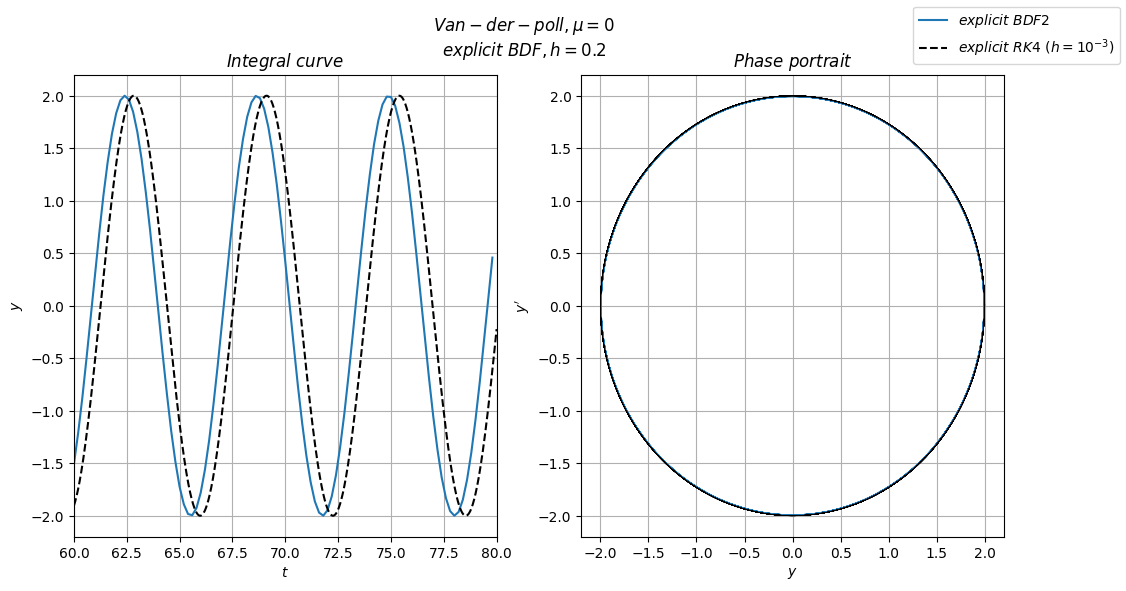

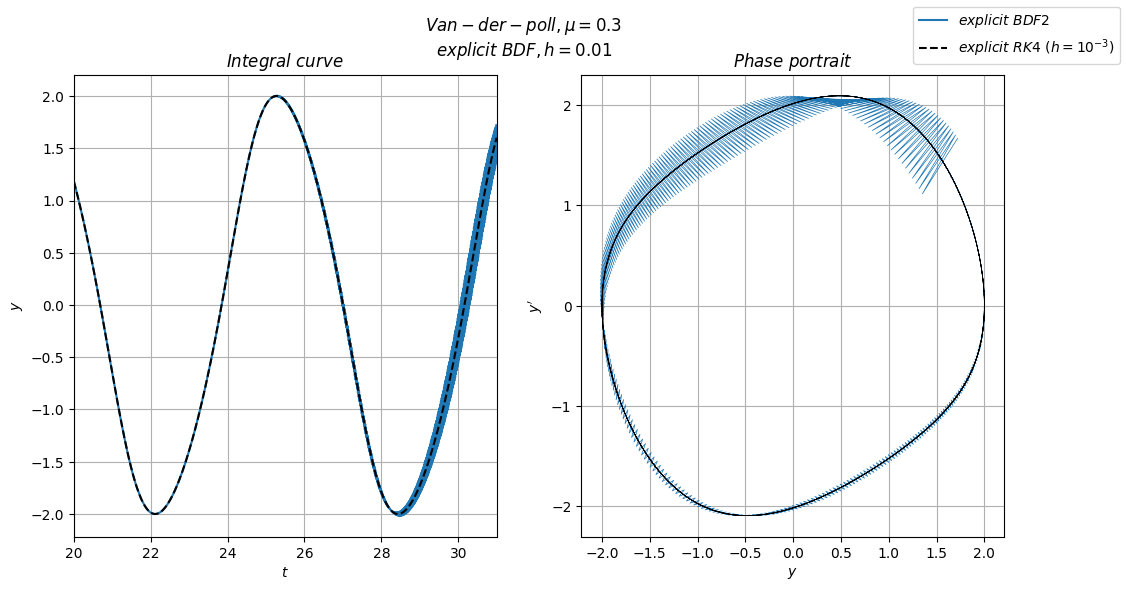

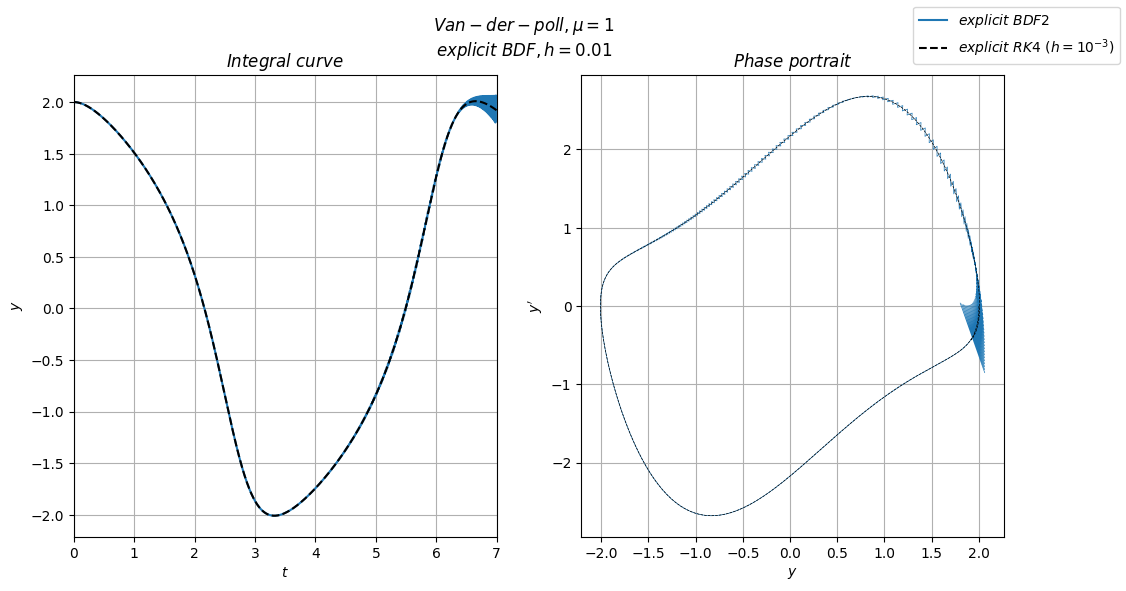

In [197]:
def solution_bdf(mu, h, tbounds=(60, 80)):
    solvers = [BDFCollection.create_e2(h),
               RungeKuttaCollection.create_e4(1e-3)]

    labels = ["$explicit~ BDF2$", "$explicit ~RK4 ~(h=10^{-3})$"]

    return task(mu, h, solvers, labels, "explicit~ BDF", tbounds)

solution_bdf(0, 2e-1)
solution_bdf(0.3, 1e-2, (20, 31))
solution_bdf(1, 1e-2, (0, 7))

> При $\mu > 0$ численное решение начинает осциллировать с неограниченно нарастающей амплитудой. То есть, применительно к данной задаче **ФДН2** выдает неустойчивые решения. <br> *Я трижды все перепроверил, код вроде правильный*